In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# A helper to compute d/dt of y w.r.t. t using autograd
def derivative(y, t):
    return torch.autograd.grad(
        y, t,
        grad_outputs=torch.ones_like(y),
        create_graph=True,
        retain_graph=True
    )[0]

In [2]:
class PINN(nn.Module):
    def __init__(self, n_hidden=40, n_layers=3):
        super(PINN, self).__init__()
        layers = []
        
        layers.append(nn.Linear(1, n_hidden))
        layers.append(nn.Tanh())
        
        for _ in range(n_layers-1):
            layers.append(nn.Linear(n_hidden, n_hidden))
            layers.append(nn.Tanh())
        
        layers.append(nn.Linear(n_hidden, 1))
        
        self.net = nn.Sequential(*layers)
    
    def forward(self, t):
        return self.net(t)

In [3]:
# Physical parameters
m=1.0
omega=2.0  # natural frequency → k = omega^2 = 4

# Initial conditions
x0_val=1.0
v0_val=0.0

In [4]:
# Time domain [0, T]
T_end = 5.0 * np.pi / omega  # one full period
N_f = 2000                   # number of collocation points
N_ic = 50                    # number of points to enforce initial conditions

# Generate collocation points uniformly in [0, T_end]
t_f = torch.linspace(0.0, T_end, N_f).view(-1,1)
t_f = t_f.requires_grad_(True)  # enable gradients for PDE residual

# Initial condition points (we only need t=0)
t_ic = torch.zeros(N_ic,1)
t_ic.requires_grad_(True)
# All have x(0)=x0_val and x'(0)=v0_val
x_ic = x0_val * torch.ones(N_ic,1)
v_ic = v0_val * torch.ones(N_ic,1)


In [5]:
# Instantiate PINN
model = PINN(n_hidden=40, n_layers=3)

# Adam optimizer for pre‐training
optimizer_Adam = torch.optim.Adam(model.parameters(), lr=1e-3)

# We'll switch to LBFGS after a few thousand iterations
optimizer_LBFGS = torch.optim.LBFGS(
    model.parameters(), 
    lr=1.0,      # step size (alpha) for LBFGS; adjust if needed
    max_iter=50000,
    tolerance_grad=1e-8,
    tolerance_change=1e-8,
    history_size=50,
    line_search_fn="strong_wolfe"
)

In [6]:
def loss_fn():
    # 1) PDE residual at collocation points
    x_pred_f = model(t_f)                           # x(t_f)
    dx_dt_f = derivative(x_pred_f, t_f)             # x'(t_f)
    d2x_dt2_f = derivative(dx_dt_f, t_f)            # x''(t_f)
    
    # PDE residual: m d2x + k x = 0  → here m=1, k=omega^2
    f = d2x_dt2_f + (omega**2) * x_pred_f
    loss_pde = torch.mean(f**2)
    
    # 2) Initial condition at t=0
    x_pred_ic = model(t_ic)                         # x(0)
    dx_dt_ic = derivative(x_pred_ic, t_ic)          # x'(0)
    
    loss_ic_x = torch.mean((x_pred_ic - x_ic)**2)
    loss_ic_v = torch.mean((dx_dt_ic - v_ic)**2)
    
    loss_total = loss_pde + loss_ic_x + loss_ic_v
    return loss_total

In [7]:
# Record loss history
loss_history = []

# 5.1 Pre‐train with Adam
epochs_adam = 10000
for it in range(epochs_adam):
    optimizer_Adam.zero_grad()
    loss = loss_fn()
    loss.backward()
    optimizer_Adam.step()
    
    if it % 2000 == 0:
        print(f"Adam iter {it}, Loss = {loss.item():.3e}")
        loss_history.append(loss.item())

# 5.2 Switch to LBFGS
def closure():
    optimizer_LBFGS.zero_grad()
    loss = loss_fn()
    loss.backward()
    return loss

print("Starting LBFGS...")
optimizer_LBFGS.step(closure)
print("LBFGS done.")

Adam iter 0, Loss = 4.736e+00
Adam iter 2000, Loss = 1.980e-01
Adam iter 4000, Loss = 1.861e-01
Adam iter 6000, Loss = 1.068e-01
Adam iter 8000, Loss = 9.503e-02
Starting LBFGS...
LBFGS done.


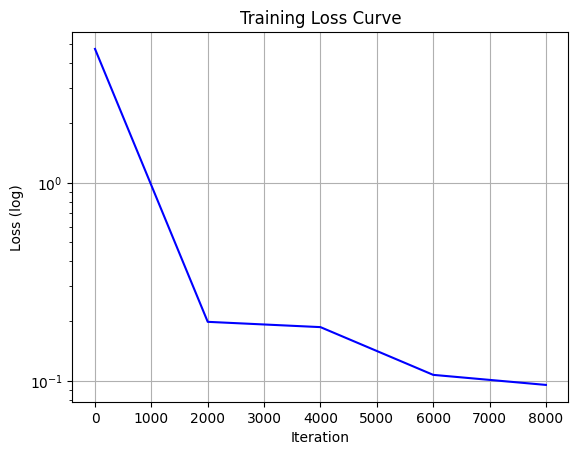

In [8]:
plt.semilogy(np.arange(0, len(loss_history))*2000, loss_history, 'b-')
plt.xlabel("Iteration")
plt.ylabel("Loss (log)")
plt.title("Training Loss Curve")
plt.grid(True)
plt.show()

In [9]:
# Generate fine test grid
t_test = torch.linspace(0.0, T_end, 200).view(-1,1).requires_grad_(False)

# True solution: x(t) = x0 cos(omega t) + (v0/omega) sin(omega t)
t_np = t_test.detach().numpy().flatten()
x_true = x0_val * np.cos(omega * t_np) + (v0_val/omega) * np.sin(omega * t_np)

In [10]:
model.eval()
with torch.no_grad():
    x_pred_test = model(t_test).detach().numpy().flatten()

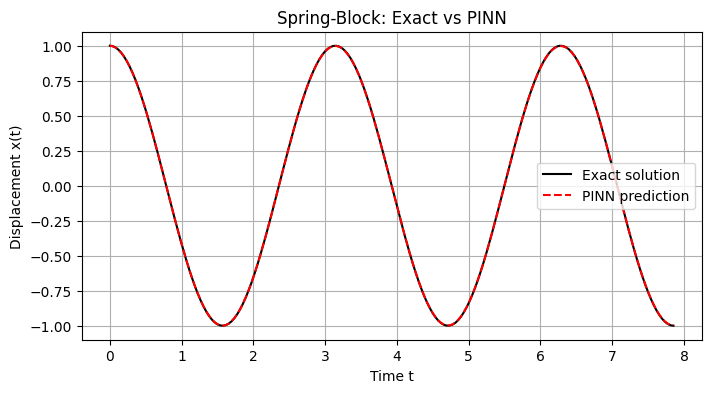

In [11]:
plt.figure(figsize=(8,4))
plt.plot(t_np, x_true, 'k-', label="Exact solution")
plt.plot(t_np, x_pred_test, 'r--', label="PINN prediction")
plt.xlabel("Time t")
plt.ylabel("Displacement x(t)")
plt.legend()
plt.title("Spring-Block: Exact vs PINN")
plt.grid(True)
plt.show()

In [12]:
rel_error = np.linalg.norm(x_pred_test - x_true, 2) / np.linalg.norm(x_true, 2)
print(f"Relative L2 Error: {rel_error:.3e}, Accuracy ≈ {100*(1-rel_error):.2f}%")

Relative L2 Error: 1.496e-03, Accuracy ≈ 99.85%
